# Advanced Regression Techniques - Ames, IA Housing Data

The purpose of this project is to predict the price of housing in the city of Ames, IA using real estate data and different regression models: Decision Tree, Random Forest, XGBoost Regression

Features such as Lot Size, Number of Bedrooms and the Age of the House are used to determine the price of real estate. 

## Root Mean Squared Error

The Root Mean Squared Error (RMSE) metric is a method of error valuation 
that will be selected to determine the best regression model.  

According to Wikipedia, RMSE is defined as the following:

Root-mean-square error (RMSE) is a measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. The RMSD represents the square root of the second sample moment of the differences between predicted values and observed values or the quadratic mean of these differences.

**RMSE** serves to aggregate the magnitudes of the errors in predictions for various data points into a single measure of predictive power. **RMSD** is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent.[https://en.wikipedia.org/wiki/Root-mean-square_deviation]

## Root Mean Log Squared Error

In the case of RMSE, the presence of outliers causes the error value to maginify to a very high value. 
Thus, RMSE is sensitive to outliers.

For this project, the **Root Mean Squared Log Error (RMSLE)** metric will be used instead!
With the RMLSE metric, outliers are drastically scaled down which minimizes their effect
on the model.

The RMSLE metric only considers the relative error between the Predicted and the Actual value.
Thus the scale of the error is not significant. Alternatively, the RMSE value **increases in magnitude if the scale of error increases.**

A key advantage of using the RMSLE is that it incurs a larger penalty for the underestimation of the Actual variable than the Overestimation.

Thus, a higher penalty is incurred when the **Predicted Value is less than the Actual Value**. Conversley, less penalty is incurred when the predicted value is more than the actual value. This is useful for scenarios where overestimating a target is less important than underestimating a target![https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a]



# Data Description


       NA	No Garage
              
       GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
              
       PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
              
       WoodDeckSF: Wood deck area in square feet

       OpenPorchSF: Open porch area in square feet

       EnclosedPorch: Enclosed porch area in square feet

       3SsnPorch: Three season porch area in square feet

       ScreenPorch: Screen porch area in square feet

       PoolArea: Pool area in square feet

       PoolQC: Pool quality
              
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
              
       Fence: Fence quality
              
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

       MiscFeature: Miscellaneous feature not covered in other categories
              
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
              
       MiscVal: $Value of miscellaneous feature

       MoSold: Month Sold (MM)

       YrSold: Year Sold (YYYY)

       SaleType: Type of sale
              
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
              
       SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       


# Import libraries

In [315]:
try:
    %reload_ext autotime
except:
    %pip install ipython-autotime
    %load_ext autotime

time: 0 ns (started: 2022-03-02 12:14:48 -07:00)


In [316]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

time: 16 ms (started: 2022-03-02 12:14:49 -07:00)


In [317]:
import numpy as np
import pandas as pd
import os

import plotly.express as px
import plotly.offline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

  
# import sklearn machine learning libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE, RFECV

%pip install shap
import shap

%pip install xgboost
from xgboost import plot_importance

%pip install category_encoders

# XGBoost ML libraries
import math
from xgboost import XGBRegressor
from xgboost import plot_importance

# Formatting options
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
time: 11.4 s (started: 2022-03-02 12:14:49 -07:00)


# Data Loading and EDA

In [318]:
# import the training dataset

url = 'https://github.com/patty-olanterns/RealEstateAmesIA/blob/main/train.csv?raw=true'
df = pd.read_csv(url, low_memory=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


time: 1.25 s (started: 2022-03-02 12:15:00 -07:00)


In [319]:
# check the data structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [320]:
# Drop the Id column
df.drop('Id', axis=1, inplace=True)

time: 15 ms (started: 2022-03-02 12:15:02 -07:00)


In [321]:
object_cols = ['MSSubClass', 'MSZoning'] 
df[object_cols] = df[object_cols].astype('object')

# Convert all int and float64 to float32
num_cols = df.select_dtypes(exclude=['object']).columns
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce', downcast='float')

time: 31 ms (started: 2022-03-02 12:15:02 -07:00)


Check the number of attributes with Missing Values

In [322]:
# Check for null data and sort by the top 10 columns
df.isnull().sum(axis=0).sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
dtype: int64

time: 15 ms (started: 2022-03-02 12:15:02 -07:00)


In [323]:
# print out a list of attributes that have null data
print(df.columns[df.isna().any()].tolist())

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
time: 0 ns (started: 2022-03-02 12:15:02 -07:00)


In [324]:
# Create Average Sale Price column using GroupBy 
g = df.groupby('YearBuilt')['SalePrice'].mean().reset_index(name='AvgSalePrice')

# Merge the AvgSalePrice column with the original DataFrame on the YearBuilt column
df = pd.merge(df, g, on ='YearBuilt', how ="inner")

# Move YearBuilt column to first index position
df = df[['YearBuilt'] + [col for col in df.columns if col != 'YearBuilt']]

# Sort YearBuilt column in ascending order
df = df.sort_values(by='YearBuilt', ascending=True).reset_index(drop=True)
df

,YearBuilt,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AvgSalePrice
0,"1,872.000",70,RM,50.000,"5,250.000",Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,8.000,5.000,"1,987.000",Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,Gd,BrkTil,TA,Fa,No,LwQ,259.000,Unf,0.000,425.000,684.000,OthW,Fa,N,SBrkr,938.000,"1,215.000",205.000,"2,358.000",0.000,0.000,2.000,0.000,4.000,1.000,TA,8.000,Typ,0.000,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,Y,0.000,54.000,20.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,12.000,"2,008.000",WD,Normal,"122,000.000","122,000.000"
1,"1,875.000",50,RL,54.000,"6,342.000",Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,1Fam,1.5Fin,5.000,8.000,"1,996.000",Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,Gd,CBlock,TA,TA,No,Unf,0.000,Unf,0.000,780.000,780.000,GasA,Gd,N,SBrkr,780.000,240.000,0.000,"1,020.000",0.000,0.000,1.000,0.000,2.000,1.000,TA,6.000,Typ,0.000,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,N,0.000,0.000,176.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,5.000,"2,010.000",WD,Normal,"94,000.000","94,000.000"
2,"1,880.000",70,RM,90.000,"9,900.000",Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,6.000,4.000,"1,950.000",Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000,TA,TA,BrkTil,TA,TA,Mn,Unf,0.000,Unf,0.000,"1,008.000","1,008.000",GasW,TA,Y,SBrkr,"1,178.000","1,032.000",0.000,"2,210.000",0.000,0.000,2.000,0.000,5.000,1.000,Fa,8.000,Typ,0.000,NaN,Detchd,"1,930.000",Unf,1.000,205.000,Fa,TA,N,0.000,48.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,5.000,"2,007.000",WD,Normal,"117,500.000","200,619.750"
3,"1,880.000",75,RM,87.000,"18,386.000",Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Fin,7.000,9.000,"2,002.000",Gable,CompShg,CemntBd,CmentBd,None,0.000,TA,TA,BrkTil,TA,TA,No,Unf,0.000,Unf,0.000,"1,470.000","1,470.000",GasA,Ex,Y,SBrkr,"1,675.000","1,818.000",0.000,"3,493.000",0.000,0.000,3.000,0.000,3.000,1.000,Gd,10.000,Typ,1.000,Ex,Attchd,"2,003.000",Unf,3.000,870.000,TA,TA,Y,302.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,5.000,"2,008.000",WD,Normal,"295,000.000","200,619.750"
4,"1,880.000",70,RM,65.000,"11,700.000",Pave,Pave,IR1,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,7.000,7.000,"2,003.000",Mansard,CompShg,Stucco,Stucco,None,0.000,Gd,TA,Stone,TA,Fa,No,Unf,0.000,Unf,0.000,"1,240.000","1,240.000",GasW,TA,N,SBrkr,"1,320.000","1,320.000",0.000,"2,640.000",0.000,0.000,1.000,1.000,4.000,1.000,Gd,8.000,Typ,1.000,Gd,Detchd,"1,950.000",Unf,4.000,864.000,TA,TA,N,181.000,0.000,386.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,5.000,"2,009.000",WD,Normal,"265,979.000","200,619.750"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,"2,009.000",160,FV,30.000,"3,000.000",Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6.000,5.000,"2,009.000",Gable,CompShg,VinylSd,VinylSd,Stone,76.000,Gd,TA,PConc,Gd,TA,Av,GLQ,294.000,Unf,0.000,318.000,612.000,GasA,Ex,Y,SBrkr,612.000,612.000,0.000,"1,224.000",0.000,0.000,2.000,

time: 125 ms (started: 2022-03-02 12:15:02 -07:00)


19/80 attributes are missing values. These cells can be filled in with imputation
or other methods or deleted.

# Exploratory Data Analysis

## Is there a correlation (+ or -) between specific house features and the SalePrice?

Example:
 - Does a renovation increase the SalePrice?
 - By how much?
 - How much of an impact does the GarageSize(1 car, 2 car) have on the SalePrice?
   

Text(0.5, 1.0, 'Feature Correlation Score')

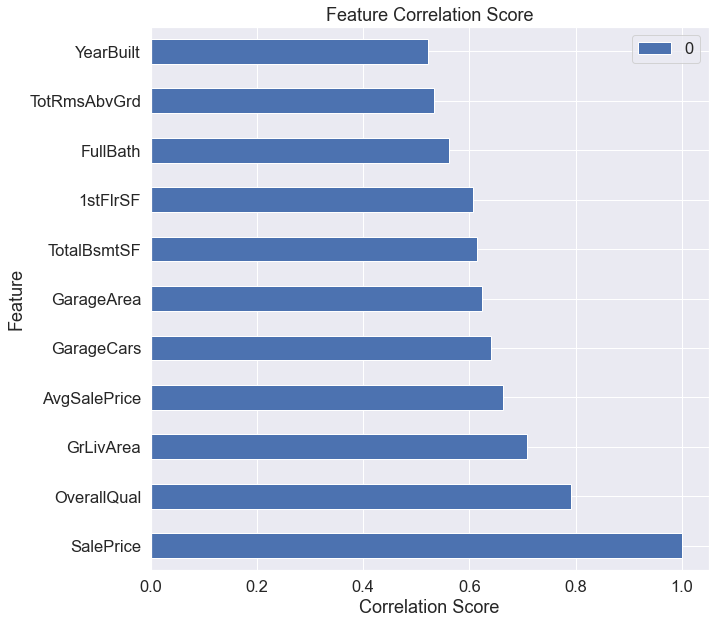

time: 297 ms (started: 2022-03-02 12:15:03 -07:00)


In [325]:
# Display top 10 positively correlated features with target (SalePrice)

# Plot average price by neighborhood
corr_neigh = pd.DataFrame(df.corrwith(df['SalePrice']).sort_values(ascending=False).head(11))
corr_neigh.plot.barh(figsize = (10,10))
plt.xlabel('Correlation Score')
plt.ylabel('Feature')
plt.title('Feature Correlation Score')


Text(0.5, 1.0, 'Ames, IA - Average Price of Home by Neighborhood')

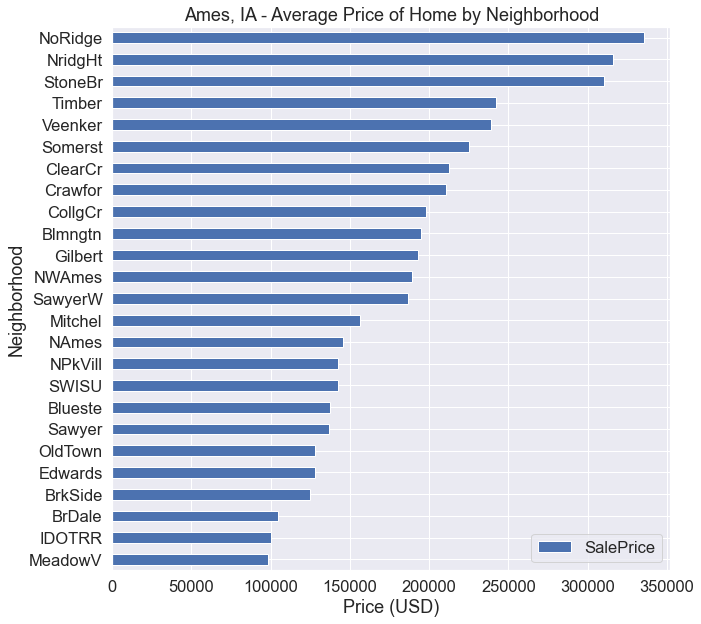

time: 391 ms (started: 2022-03-02 12:15:03 -07:00)


In [326]:
a = pd.DataFrame(df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=True))
a.plot.barh(figsize = (10,10))
plt.xlabel('Price (USD)')
plt.title('Ames, IA - Average Price of Home by Neighborhood')

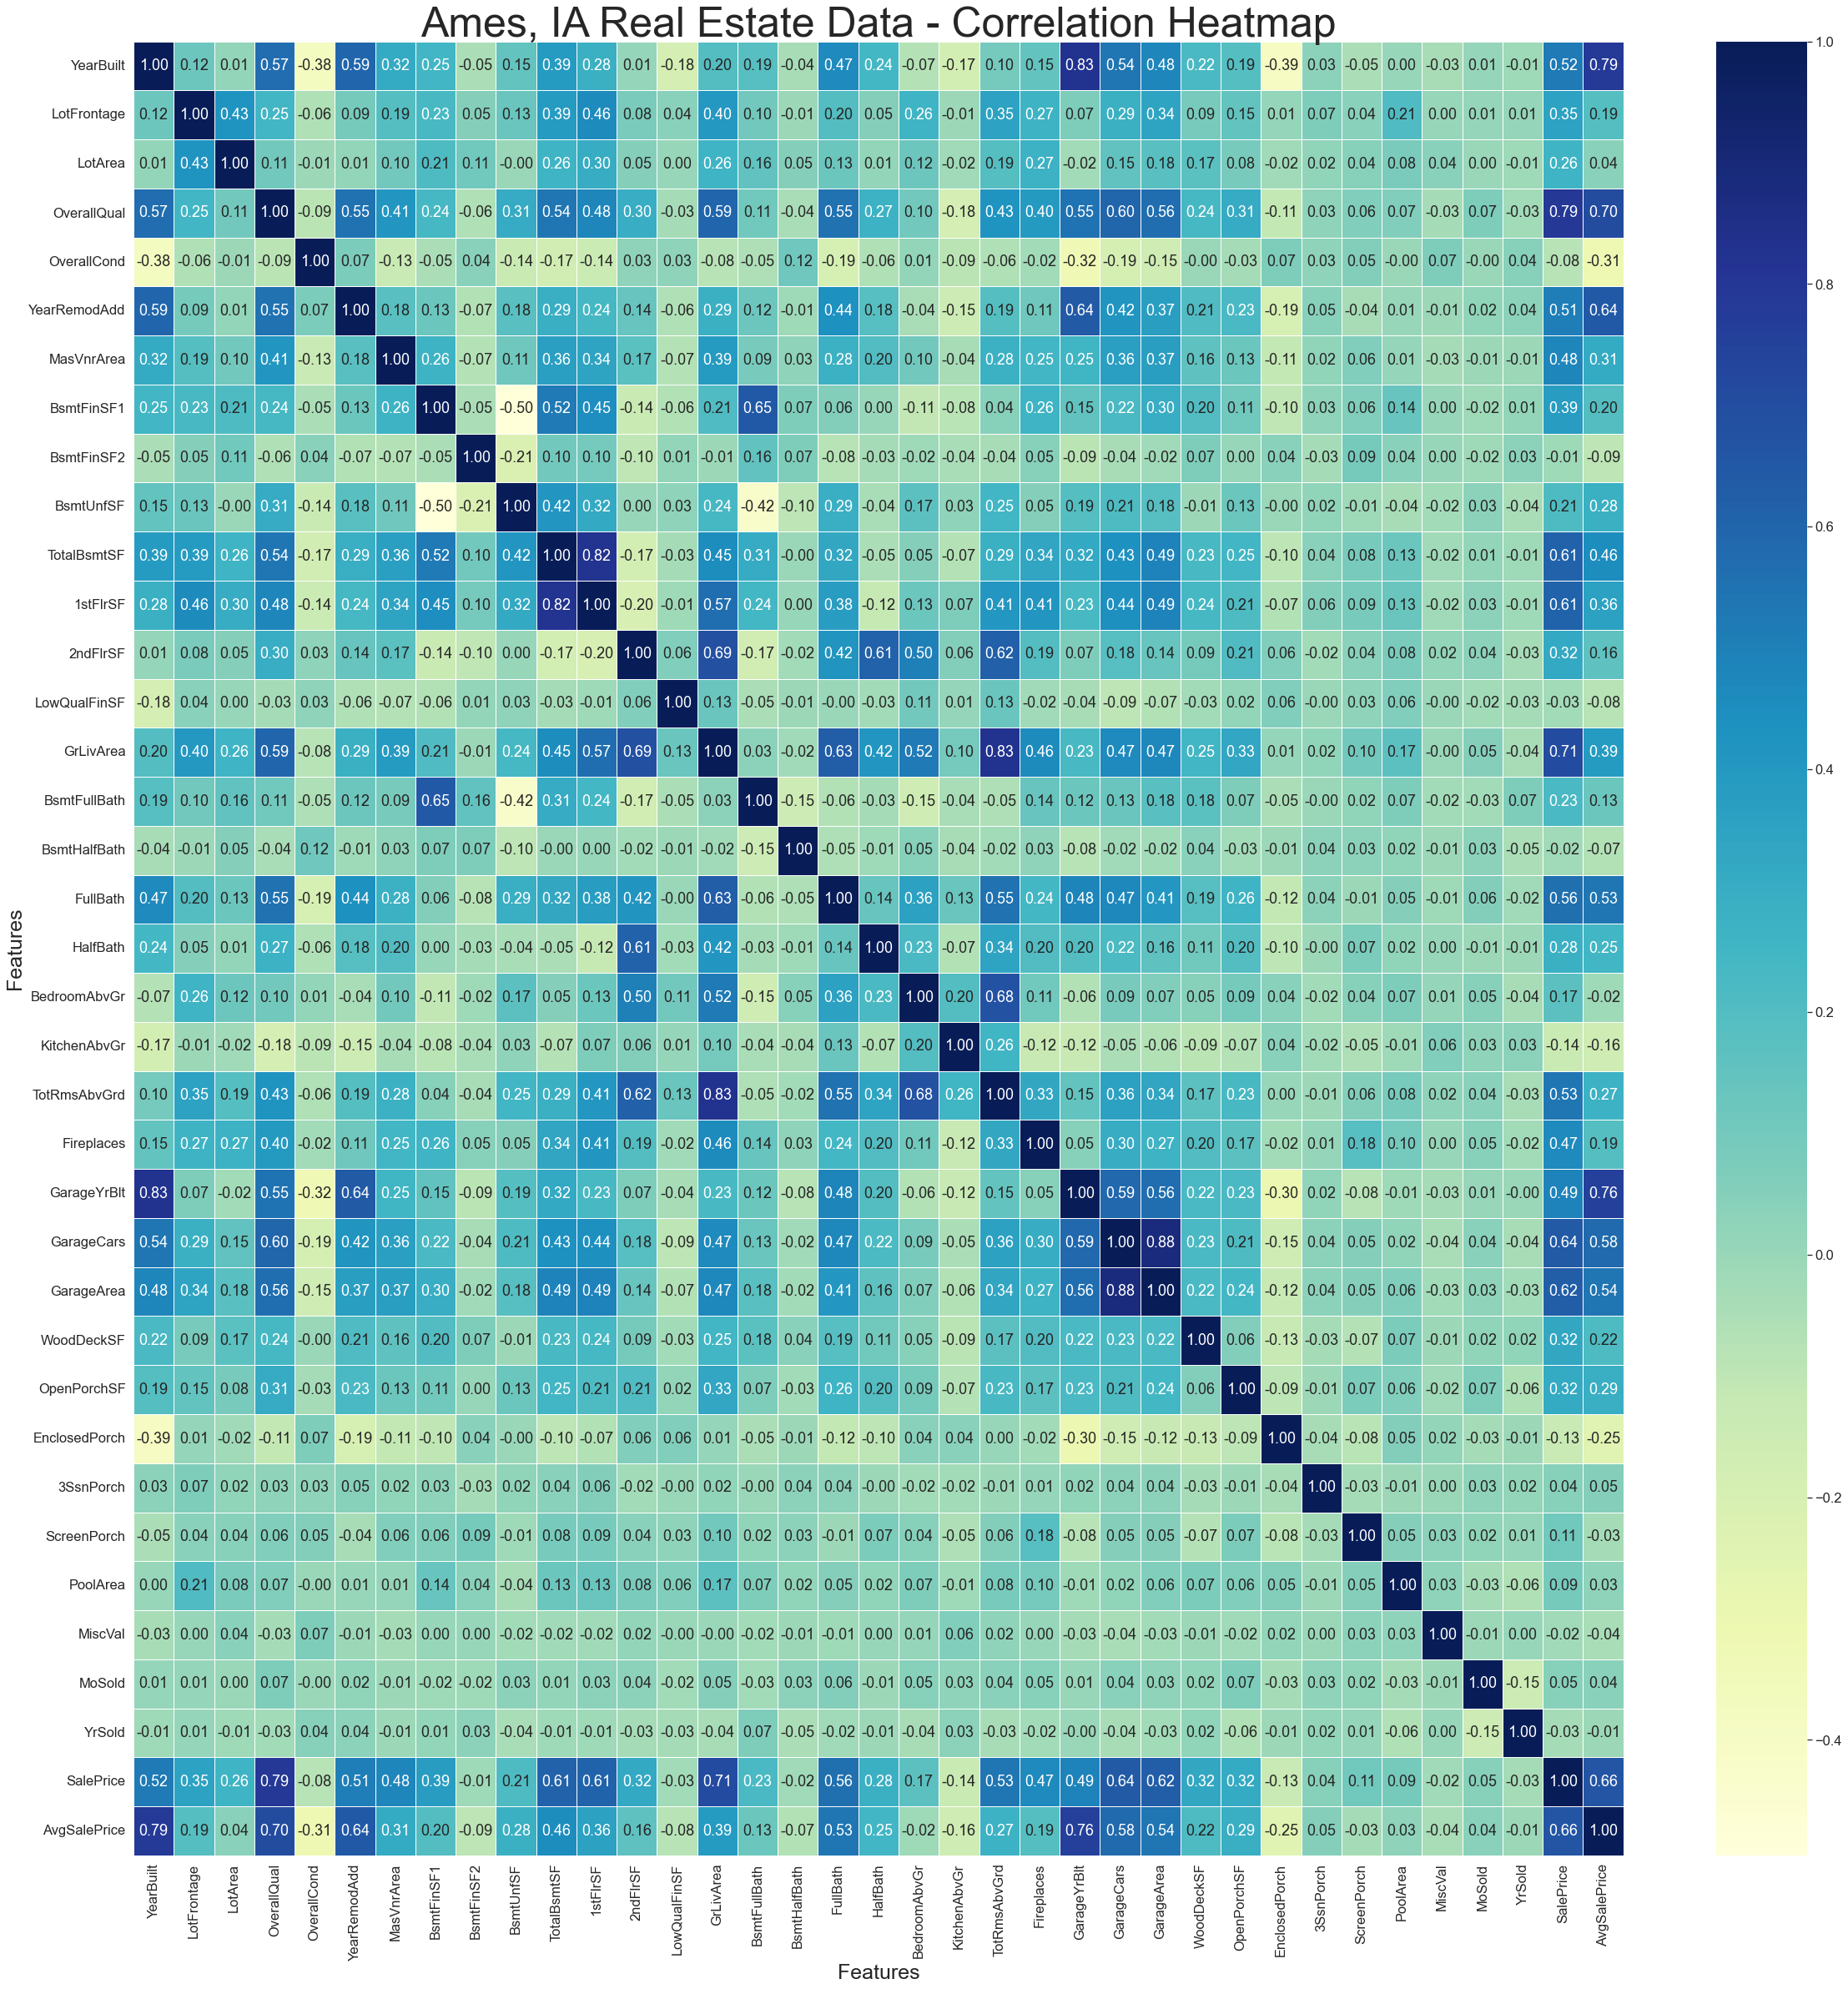

time: 8.11 s (started: 2022-03-02 12:15:04 -07:00)


In [327]:
# Plot the data using a heat map
corr_vals = df.corr()

# Create Seaborn heat map and save as .png file
plt.rcParams['figure.figsize'] = 40,40
sns.set(font_scale=1.5)

ax = sns.heatmap(df.corr(),annot=True,fmt=".2f",cmap="YlGnBu",linewidths=0.5)
plt.title("Ames, IA Real Estate Data - Correlation Heatmap", fontsize=50)
plt.xlabel("Features", fontsize=25)
plt.ylabel("Features", fontsize=25)

plt.savefig('Ames_IA_RealEstateDataCorrelationHeatmap')
plt.show()

## Plot AveragePriceOfHome by Neighborhood

Text(0.5, 1.0, 'Ames, IA - Average Price of Home by Neighborhood')

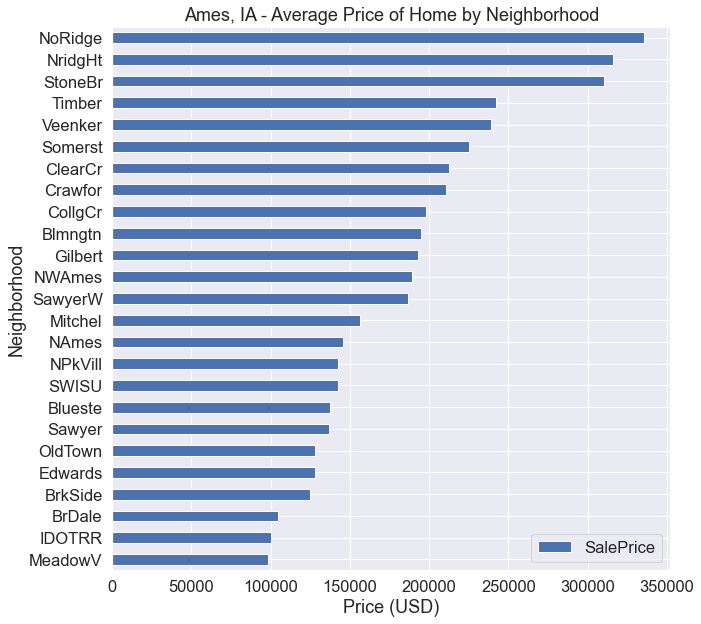

time: 391 ms (started: 2022-03-02 12:15:12 -07:00)


In [328]:
# Plot average price by neighborhood
a = pd.DataFrame(df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=True))
a.plot.barh(figsize = (10,10))
plt.xlabel('Price (USD)')
plt.title('Ames, IA - Average Price of Home by Neighborhood')

## What factors should we consider for SalePrice? 

Factors to consider: 

- Year of Renovations (YearRemodAdd)
- Overall Quality
- Kitchen
- Roof
- Number of years since last Renovation ('YearsSinceReno')
- Age of House (YearBuilt)
- Total Square Footage (TotalSF)
- Lot Size
- Area of town (crime, race, earnings, etc.)
- Condition of House (HouseQuality)
- Basement quality etc..

In [329]:
# combine 1st, 2nd and finished basement sqft together (1stFlrSF, 2ndFlrSF)
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YearBuilt      1460 non-null   float32
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float32
 4   LotArea        1460 non-null   float32
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   float32
 18  OverallC

### Create Histogram for TotalSF
- Determine and drop outlier data

In [330]:
# Determine outliers for TotalSF
fig = px.histogram(df, x='TotalSF', 
                   marginal='box',
                   histnorm = 'percent',
                   title='TotalSF Histogram')

fig.show()

time: 94 ms (started: 2022-03-02 12:15:12 -07:00)


A standard procedure in a normal distribution in statistics is to drop values that have a z-score that is greater than 3.
This means any value that is **3 standard deviations higher than the mean value**.

Filter out all outlier values with a z-score > 3

In [331]:
# Filter other columns based on a single column
from scipy import stats
df_filtered = df[(np.abs(stats.zscore(df['TotalSF']) < 3))]

print("Old Shape: ", df.shape)
print("New Shape: ", df_filtered.shape)

Old Shape:  (1460, 82)
New Shape:  (1449, 82)
time: 16 ms (started: 2022-03-02 12:15:13 -07:00)


Print min and max TotalSF values in new dataset

In [332]:
df_filtered['TotalSF'].max()

4963.0

time: 15 ms (started: 2022-03-02 12:15:13 -07:00)


In [333]:
df_filtered['TotalSF'].min()


334.0

time: 0 ns (started: 2022-03-02 12:15:13 -07:00)


# Preprocessing

- Features and target selection
- Train-Test Split
- Numeric/Category Pipeline Setup
  - Define numerical and categorical columns in training data
  - Replace null numeric values with SimpleImputer()
  - Replace null categorical values (string, object, bool) with most frequent values by column
  - Encode each categorical value as unique category using OneHotEncoder()
  - Setup preprocessor ColumnTransformer Pipeline with numeric and category transformers as steps
    in process

## Features and Target selection

In [334]:
# Select prediction variables and target variable

features = [x for x in df.columns if x not in ['SalePrice']]
X = df[features] # Prediction variable
y = df['SalePrice'] # Target variable

time: 0 ns (started: 2022-03-02 12:15:13 -07:00)


In [335]:
# Check number of variables
len(features)

81

time: 0 ns (started: 2022-03-02 12:15:13 -07:00)


## Train-Test Split

In [336]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

time: 15 ms (started: 2022-03-02 12:15:13 -07:00)


## Numeric and Category Pipeline setup 
 - XGBoost can ONLY interpret numeric values!
 - In order to interpret category and numeric values, all category values
   must be encoded using OneHotEncoder. Each string feature will be its own category

In [337]:
# Split the data up in to numerical data (int and float) and categorical 
# data (objects, names, words etc.)
num_cols = [cname for cname in X_train.columns 
            if X_train[cname].dtype == "float32"]

category_cols = [cname for cname in X_train.columns 
                 if X_train[cname].nunique() < 22 and 
                 X_train[cname].dtype == "object"]

# SimpleImputer is a function that replaces null cell values with the mean,
# median, most frequent or a fixed value based on the dataset used
numerical_transformer = SimpleImputer(strategy='constant')

# The same process can be applied to categorical values (strings, objects, etc.)
# and automated using the Pipeline function
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transform all data in columns using the preprocessor and ColumnTransformer function
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, category_cols)
])

time: 31 ms (started: 2022-03-02 12:15:13 -07:00)


# Create Root Mean Squared Log Error function (RMSLE)

RMSLE (Root Mean Square Log Error) must be used for this dataset to compare the predicted
data with the valid data. It's not a default scoring metric available
as a tool in Sci-kit Learn.

In [338]:
def root_mean_squared_log_error(y_valid, y_preds):
    # Calc rmse of log(y_test) and log(y_pred)
    
    if len(y_preds) != len(y_valid): return 'error_mismatch'
    y_preds_new = [math.log(x) for x in y_preds]
    y_valid_new = [math.log(x) for x in y_valid]
    return mean_squared_error(y_valid_new,y_preds_new,squared=False)

time: 0 ns (started: 2022-03-02 12:15:14 -07:00)


# Model Selection

## Model 1: DecisionTree

In [339]:
# Import model from sklearn
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)

# Setup a Pipeline processing function
tree_clf = Pipeline(steps=[('preprocessor',preprocessor),
                           ('tree_model',tree_model)
                          ])


# Fit the training dataset to the model
tree_clf.fit(X_train,y_train)

# Set tree_preds to the test feature data (X_test)
tree_preds = tree_clf.predict(X_test)

# Print the RMSLE results
print('RMSLE:', root_mean_squared_log_error(y_test,tree_preds))

RMSLE: 0.1949164403323455
time: 172 ms (started: 2022-03-02 12:15:14 -07:00)


## Model II: Random Forest regressor

In [340]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

rand_clf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf',rf_model)
                           ])

# Fit the training data to the model
rand_clf.fit(X_train, y_train)

rand_preds = rand_clf.predict(X_test)

print('RMSLE:', root_mean_squared_log_error(y_test, rand_preds))

RMSLE: 0.1384630186725369
time: 6.89 s (started: 2022-03-02 12:15:14 -07:00)


## Model III: XGB Regressor

### Run Pipeline process and fit train-test data

In [341]:
xgb_model = XGBRegressor(n_estimators=1000,
                         max_depth=5, min_child_weight=1, 
                         gamma=0, 
                         booster='gbtree', 
                         learning_rate=0.02, 
                         objective='reg:squarederror', 
                         random_state=42)

# Run Pipeline
xgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('xgb_model', xgb_model)
                          ])

# Fit the model
xgb_clf.fit(X_train, y_train, xgb_model__verbose=False)

# Predict RealEstate value
xgb_preds = xgb_clf.predict(X_test)

# Print RMSLE result
print('RMSLE:', root_mean_squared_log_error(y_test, xgb_preds))
print('\n')

RMSLE: 0.12404628445875912


time: 3.06 s (started: 2022-03-02 12:15:21 -07:00)


### Compare model values

In [342]:
print('Decision Tree RMSLE:', root_mean_squared_log_error(y_test, tree_preds))
print('Random Forest RMSLE:', root_mean_squared_log_error(y_test, rand_preds))
print('XGBoost Regressor RMSLE:', root_mean_squared_log_error(y_test, xgb_preds))

Decision Tree RMSLE: 0.1949164403323455
Random Forest RMSLE: 0.1384630186725369
XGBoost Regressor RMSLE: 0.12404628445875912
time: 0 ns (started: 2022-03-02 12:15:24 -07:00)


The XGBoost model has the lowest score of the three models!

### Run GridSearchCV (CrossValidation) to select best parameters

Use the GridSearchCV model to determine the best parameters to select for 
Feature Engineering.

In [343]:
param_grid={"xgb_model__nlearning_rate": (0.05, 0.10, 0.15),
                        "xgb_model__nmax_depth": [6],
                        "xgb_model__nmin_child_weight": [1],
                        "xgb_model__ngamma":[0.0, 0.1, 0.2],
                        "xgb_model__ncolsample_bytree":[ 0.3, 0.4]}

grid = GridSearchCV(xgb_clf, 
            cv=3, param_grid=param_grid, 
            scoring=None, verbose=True, n_jobs=-1)

grid.fit(X_train, y_train)
print('\n All results:')
print(grid.cv_results_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[12:17:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "ncolsample_bytree", "ngamma", "nlearning_rate", "nmax_depth", "nmin_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



 All results:
{'mean_fit_time': array([15.73128231, 15.45194491, 15.91362651, 16.45931355, 16.56197786,
       17.97430285, 18.6359636 , 18.75563478, 16.37699556, 16.70333815,
       16.92121792, 17.22264028, 17.25863846, 16.42118605, 15.96379081,
       16.20979452, 13.04916048, 12.65850035]), 'std_fit_time': array([0.39375646, 0.19770561, 0.48523621, 0.12775159, 0.06520499,
       0.95666827, 0.07654611, 0.09505369, 0.11263297, 0.08715871,
   

In [344]:
print('\n Best estimator:')
print(grid.best_estimator_)


 Best estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['YearBuilt', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                            

In [345]:
print('\n Best score:')
print(grid.best_score_ * 2 - 1)


 Best score:
0.5971043282380755
time: 0 ns (started: 2022-03-02 12:17:26 -07:00)


In [346]:
print('\n Best parameters:')
print(grid.best_params_)


 Best parameters:
{'xgb_model__ncolsample_bytree': 0.3, 'xgb_model__ngamma': 0.0, 'xgb_model__nlearning_rate': 0.05, 'xgb_model__nmax_depth': 6, 'xgb_model__nmin_child_weight': 1}
time: 0 ns (started: 2022-03-02 12:17:26 -07:00)


In [347]:
print('\n Feature Importances:')
feat_array = grid.best_estimator_.named_steps["xgb_model"].feature_importances_
df_feat = pd.DataFrame(feat_array.reshape(feat_array.shape), columns=['FEAT_IMPOR_SCORE']).sort_values(by='FEAT_IMPOR_SCORE',ascending=False).reset_index(drop=True)
df_feat.head(10)


 Feature Importances:


,FEAT_IMPOR_SCORE
0,0.325
1,0.122
2,0.087
3,0.057
4,0.040
5,0.036
6,0.026
7,0.026
8,0.020
9,0.016


time: 15 ms (started: 2022-03-02 12:17:26 -07:00)


## Model IV: Run high performance XGB regressor model

In [348]:
hp_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

hp_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('hp_model', hp_model)
                     ])

hp_clf.fit(X_train, y_train, hp_model__verbose=False)

hp_preds = hp_clf.predict(X_test)

print('High Performance XGB Regressor RMSLE:', root_mean_squared_log_error(y_test, hp_preds))

High Performance XGB Regressor RMSLE: 0.12024161539809704
time: 2.45 s (started: 2022-03-02 12:17:26 -07:00)


# Final model Setup

Feature Engineering

In [349]:
X.columns.to_list()

['YearBuilt',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'Enc

time: 16 ms (started: 2022-03-02 12:17:29 -07:00)


In [350]:
print(set(X['SaleCondition']))

{'AdjLand', 'Abnorml', 'Alloca', 'Normal', 'Partial', 'Family'}
time: 0 ns (started: 2022-03-02 12:17:29 -07:00)


In [351]:
print(X['YearBuilt'].head())
print('\n')
print(X['YearRemodAdd'].head())

0   1,872.000
1   1,875.000
2   1,880.000
3   1,880.000
4   1,880.000
Name: YearBuilt, dtype: float32


0   1,987.000
1   1,996.000
2   1,950.000
3   2,002.000
4   2,003.000
Name: YearRemodAdd, dtype: float32
time: 0 ns (started: 2022-03-02 12:17:29 -07:00)


In [352]:
print(set(X['YrSold']))
print(set(X['MoSold']))

{2006.0, 2007.0, 2008.0, 2009.0, 2010.0}
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0}
time: 16 ms (started: 2022-03-02 12:17:29 -07:00)


In [353]:
print(set(X['ExterQual']))
print(set(X['ExterCond']))

{'TA', 'Gd', 'Ex', 'Fa'}
{'Fa', 'Ex', 'TA', 'Po', 'Gd'}
time: 0 ns (started: 2022-03-02 12:17:30 -07:00)


In [354]:
print(set(X['YearBuilt']))
print('\n')
print(set(X['OverallQual']))

{1872.0, 1875.0, 1880.0, 1882.0, 1885.0, 1890.0, 1892.0, 1893.0, 1898.0, 1900.0, 1904.0, 1905.0, 1906.0, 1908.0, 1910.0, 1911.0, 1912.0, 1913.0, 1914.0, 1915.0, 1916.0, 1917.0, 1918.0, 1919.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0}


{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
time: 0 ns (started: 2022-03-02 12:17:30 -07:00)


In [355]:
print(set(X['BedroomAbvGr']))
print(set(X['FullBath']))
print(set(X['HalfBath']))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0}
{0.0, 1.0, 2.0, 3.0}
{0.0, 1.0, 2.0}
time: 0 ns (started: 2022-03-02 12:17:30 -07:00)


### Feature notes

Based on the features in the columns, a few things stand out:
    
  - Subtracting YearBuilt from YearRemodAdd determines how recent renovation was
    completed (adds value to the house).
  - Lot geometry can be determined by dividing LotArea by LotFrontage. If the       lot is a good shape, it'll sell better. If it's strange than it may be less
    likely to sell.
  - Location in Ames? Is their high crime in the area? What is the income          level     in the neighborhood?  Is     it close to the downtown area or accessible to              shopping/university/transit/major road networks?
   
  - Features to combine:
       - YrSold and MoSold
       - Condition1 and Condition2
       - ExterQual and ExterCont
       - YearBuilt and OverallQual
       - Is there a finished basement?
       - Finished basement sqft
       
    

In [356]:
# Make a copy of the features (X values)
X_feat_eng = X.copy()

time: 0 ns (started: 2022-03-02 12:17:30 -07:00)


In [357]:
# Create the combined features
X_feat_eng['YearsSinceReno'] = X_feat_eng['YearRemodAdd'] - X_feat_eng['YearBuilt']
X_feat_eng['LotShape'] = X_feat_eng['LotArea'] / X_feat_eng['LotFrontage']
X_feat_eng['LandTopo'] = X_feat_eng['LandSlope'] + '_' + X_feat_eng['LandContour']
X_feat_eng['ValueRating'] = X_feat_eng['YearBuilt'] * X_feat_eng['OverallQual']
X_feat_eng['FinishedBsmt'] = X_feat_eng['BsmtFinSF1'] > 0
X_feat_eng['GarageVal'] = X_feat_eng['YearBuilt'] * X_feat_eng['GarageCars']
X_feat_eng['MiscVal'] = X_feat_eng['Fireplaces'] + X_feat_eng['OverallQual']  
X_feat_eng = X_feat_eng.drop(columns=['GarageCars','AvgSalePrice'])

time: 16 ms (started: 2022-03-02 12:17:30 -07:00)


## Display top correlated features

Text(0.5, 1.0, 'Final Feature Correlation Chart')

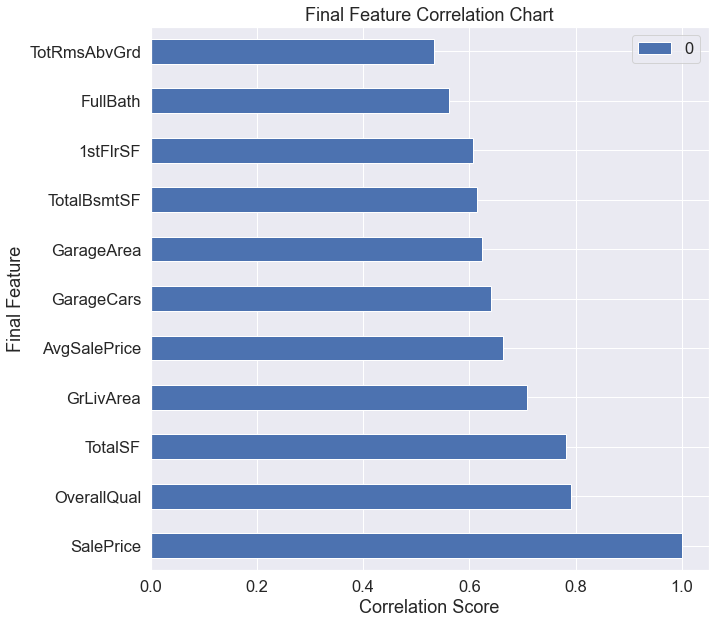

time: 250 ms (started: 2022-03-02 12:17:30 -07:00)


In [358]:
# Display top 10 positively correlated new features with target (SalePrice)

corr_neigh = pd.DataFrame(df.corrwith(df['SalePrice']).sort_values(ascending=False).head(11))
corr_neigh.plot.barh(figsize = (10,10))
plt.xlabel('Correlation Score')
plt.ylabel('Prediction Variables')
plt.title('Final Variable Correlation Chart: Prediction Variables vs. Target Variable (SalePrice')

In [359]:
# Split the data up in to numerical data (int and float) and categorical 
# data (objects, names, words etc.)
feat_num_cols = [cname for cname in X_feat_eng.columns 
            if X_feat_eng[cname].dtype in ['float32']]

feat_category_cols = [cname for cname in X_feat_eng.columns 
                 if X_feat_eng[cname].nunique() < 22 and 
                 X_feat_eng[cname].dtype in ['object', 'bool']]

# SimpleImputer is a function that replaces null cell values with the mean,
# median, most frequent or a fixed value based on the dataset used
feat_numerical_transformer = SimpleImputer(strategy='constant')

# The same process can be applied to categorical values (strings, objects, etc.)
# and automated using the Pipeline function
feat_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transform all data in columns using the preprocessor and ColumnTransformer function
feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', feat_numerical_transformer, feat_num_cols),
        ('cat', feat_categorical_transformer, feat_category_cols)
])

time: 16 ms (started: 2022-03-02 12:17:31 -07:00)


### Run the final Feature model (XGBRegressor)

In [360]:
feature_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=0.0, monotone_constraints='()',
             n_estimators=1250, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)


feature_clf = Pipeline(steps=[('feature_preprocessor', feature_preprocessor),
                                ('feature_model', feature_model)           
                                ])
# Perform train-test split
feature_X_train, feature_X_valid, feature_y_train, feature_y_valid = train_test_split(X_feat_eng, y, random_state=42)

# Fit the training dataset
feature_clf.fit(feature_X_train, feature_y_train)

# Feature predictions using validation feature data (test)
feature_preds = feature_clf.predict(feature_X_valid)

print('Final XGBRegressor Model RMSLE:', root_mean_squared_log_error(feature_y_valid, feature_preds))

Final XGBRegressor Model RMSLE: 0.1195306922395576
time: 3.22 s (started: 2022-03-02 12:17:31 -07:00)


## Conclusion

The final XGBoost RMSLE score of **0.119** is an excellent improvement over the initial score of **0.124**.

This indicates that there is ~ a 12 percent difference between the Predicted RealEstatePrice and ActualRealEstate price.
Thus, the XGBoost Regressor model is 88 percent accurate when reducing outlier values (z-score < 3) and using the RMSLE
metric.